In [1]:
import matplotlib.pyplot as plt
import numpy as np
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag
import re
from PIL import Image, ImageDraw
from IPython.display import display
import csv
from geopy import distance

## extract data

extract sensor data from 'data.txt' and read test data from 'test_data.csv'

In [2]:
def extract_sensor_data(file_name):
    gps_data = []
    with open(file_name) as f:
        for line in f:
            record = line.strip()

            if re.match(r"Latitud\/Longitud: (.*), (.*)", record):
                gps_data.append(list(map(float, re.match(r"Latitud\/Longitud: (.*), (.*)", record).groups())))

    return gps_data

In [3]:
def get_test_data():
    test_data = []
    with open('test_data.csv') as csvfile:
     spamreader = csv.reader(csvfile, delimiter=',')
     for row in spamreader:
         test_data.append(list(map(float, row)))
    return test_data

In [4]:
test_data = get_test_data()
len(test_data)

35376

In [5]:
data = extract_sensor_data('data.text')
len(data)

107

In [6]:
uni = extract_sensor_data('uni.txt')
len(uni)

933

In [7]:
def remove_noise(point, points):
    t = 0.01
    print(point, points)
    if abs(point[0] - np.mean(points[:,0])) > t:
        print(point, points)
        return True
    if abs(point[1] - np.mean(points[:,1])) > t:
        return True
    return False

In [8]:
def slide_window_norm(data):
    np_data = np.array(data)
    window_size = 5
    norm = []
    loop_data = np.copy(np_data)
    i = 0
    for d in loop_data:
        s = i - window_size
        e = i + window_size
        if i < window_size:
            s = 0
        if i > len(np_data) - window_size:
            e = len(np_data)
        if remove_noise(d, np_data[s:i]):
            np_data = np.delete(np_data, i, 0)
            continue
        px = np.mean(np_data[s:i, 0])
        py = np.mean(np_data[s:i, 1])
        if i == 0:
            px = np_data[i, 0]
            py = np_data[i, 1]
        norm.append([px, py])
        i += 1
    return norm

In [9]:
norm_uni = slide_window_norm(uni)

[35.7025  51.35143] []
[35.70251 51.35145] [[35.7025  51.35143]]
[35.70251 51.35147] [[35.7025  51.35143]
 [35.70251 51.35145]]
[35.70251 51.35147] [[35.7025  51.35143]
 [35.70251 51.35145]
 [35.70251 51.35147]]
[35.70253 51.35145] [[35.7025  51.35143]
 [35.70251 51.35145]
 [35.70251 51.35147]
 [35.70251 51.35147]]
[35.70253 51.35144] [[35.7025  51.35143]
 [35.70251 51.35145]
 [35.70251 51.35147]
 [35.70251 51.35147]
 [35.70253 51.35145]]
[35.70254 51.35142] [[35.70251 51.35145]
 [35.70251 51.35147]
 [35.70251 51.35147]
 [35.70253 51.35145]
 [35.70253 51.35144]]
[35.70254 51.3514 ] [[35.70251 51.35147]
 [35.70251 51.35147]
 [35.70253 51.35145]
 [35.70253 51.35144]
 [35.70254 51.35142]]
[35.70261 51.35139] [[35.70251 51.35147]
 [35.70253 51.35145]
 [35.70253 51.35144]
 [35.70254 51.35142]
 [35.70254 51.3514 ]]
[35.7026 51.3514] [[35.70253 51.35145]
 [35.70253 51.35144]
 [35.70254 51.35142]
 [35.70254 51.3514 ]
 [35.70261 51.35139]]
[35.70261 51.35139] [[35.70253 51.35144]
 [35.70254 51.

/Users/mj/Documents/course/az/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/mj/Documents/course/az/venv/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
len(norm_uni)

924

In [11]:
norm_uni[:10]

[[35.7025, 51.35143],
 [35.7025, 51.35143],
 [35.702505, 51.35144],
 [35.702506666666665, 51.35145],
 [35.702507499999996, 51.351455],
 [35.702512, 51.351454000000004],
 [35.702518, 51.351456000000006],
 [35.702524, 51.35145],
 [35.70253, 51.351436],
 [35.702549999999995, 51.35142]]

In [12]:
uni[:10]

[[35.7025, 51.35143],
 [35.70251, 51.35145],
 [35.70251, 51.35147],
 [35.70251, 51.35147],
 [35.70253, 51.35145],
 [35.70253, 51.35144],
 [35.70254, 51.35142],
 [35.70254, 51.3514],
 [35.70261, 51.35139],
 [35.7026, 51.3514]]

### locate data to map image

In [13]:
def scale_to_img(lat_lon, h_w, points):
    old = (points[2], points[0])
    new = (0, h_w[1])
    y = ((lat_lon[0] - old[0]) * (new[1] - new[0]) / (old[1] - old[0])) + new[0]
    old = (points[1], points[3])
    new = (0, h_w[0])
    x = ((lat_lon[1] - old[0]) * (new[1] - new[0]) / (old[1] - old[0])) + new[0]
    return int(x), h_w[1] - int(y)


def plot_data_on_map(gps_data, mapName, resultMapName, points):
    image = Image.open(mapName, 'r')  # Load map image.
    img_points = []
    for d in gps_data:
        x1, y1 = scale_to_img(d, (image.size[0], image.size[1]), points)  # Convert GPS coordinates to image coordinates.
        img_points.append((x1, y1))
    draw = ImageDraw.Draw(image)
    draw.line(img_points, fill=(255, 0, 0), width=2)  # Draw converted records to the map image.

    image.save(resultMapName)

In [14]:
plot_data_on_map(test_data, 'map2.png', 'resultMap2.png', (45.8357, 15.9645, 45.6806, 16.1557))
plot_data_on_map(data, 'map.png', 'resultMap.png', (35.71138, 51.34097, 35.70805, 51.34548))
plot_data_on_map(uni, 'map_uni.png', 'resultMap_uni.png', (35.70626, 51.34632, 35.69958, 51.35533))
plot_data_on_map(norm_uni, 'map_uni.png', 'resultMap_uni_norm.png', (35.70626, 51.34632, 35.69958, 51.35533))

map image of sensor data and test data:

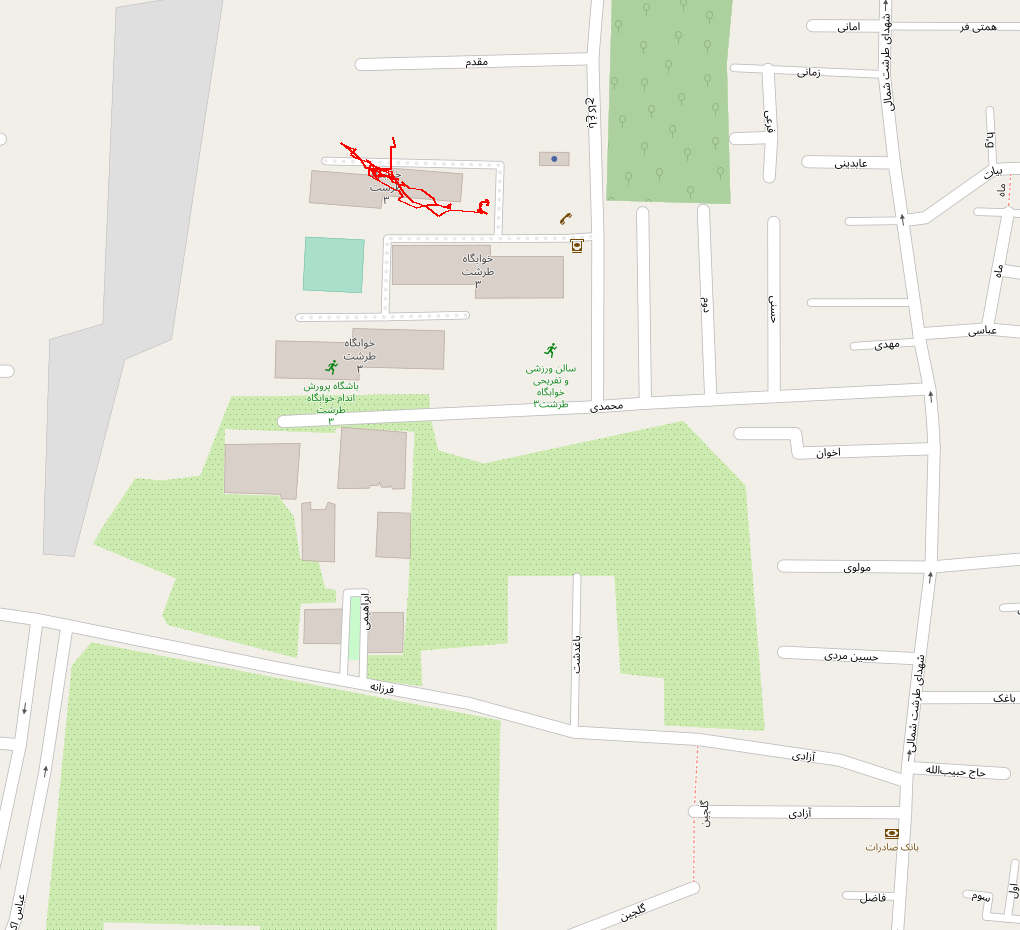

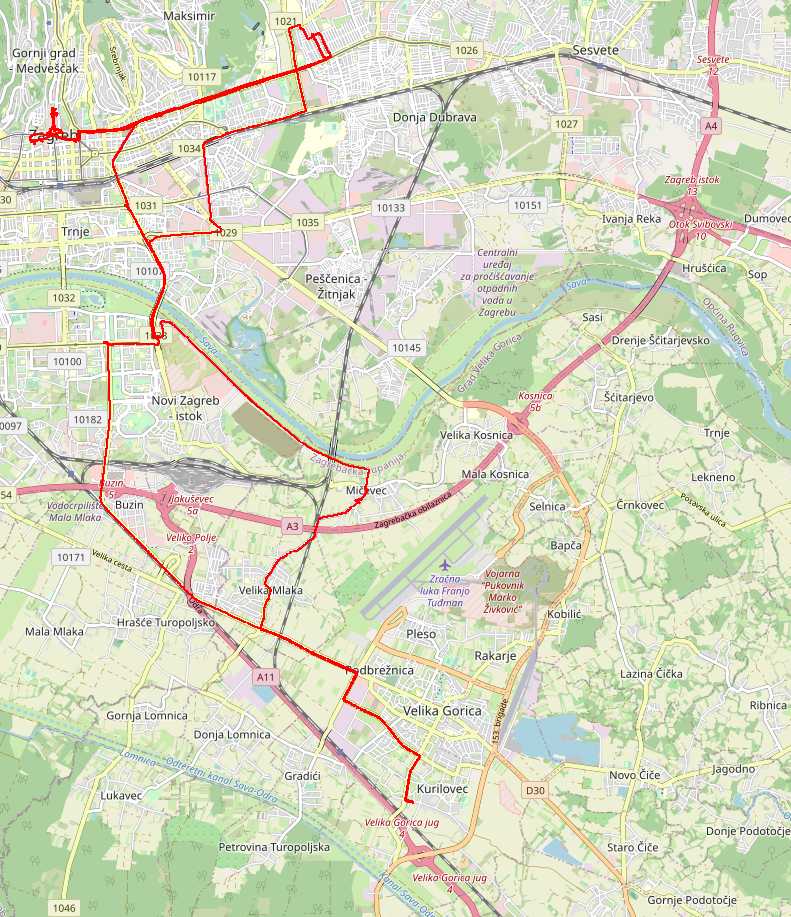

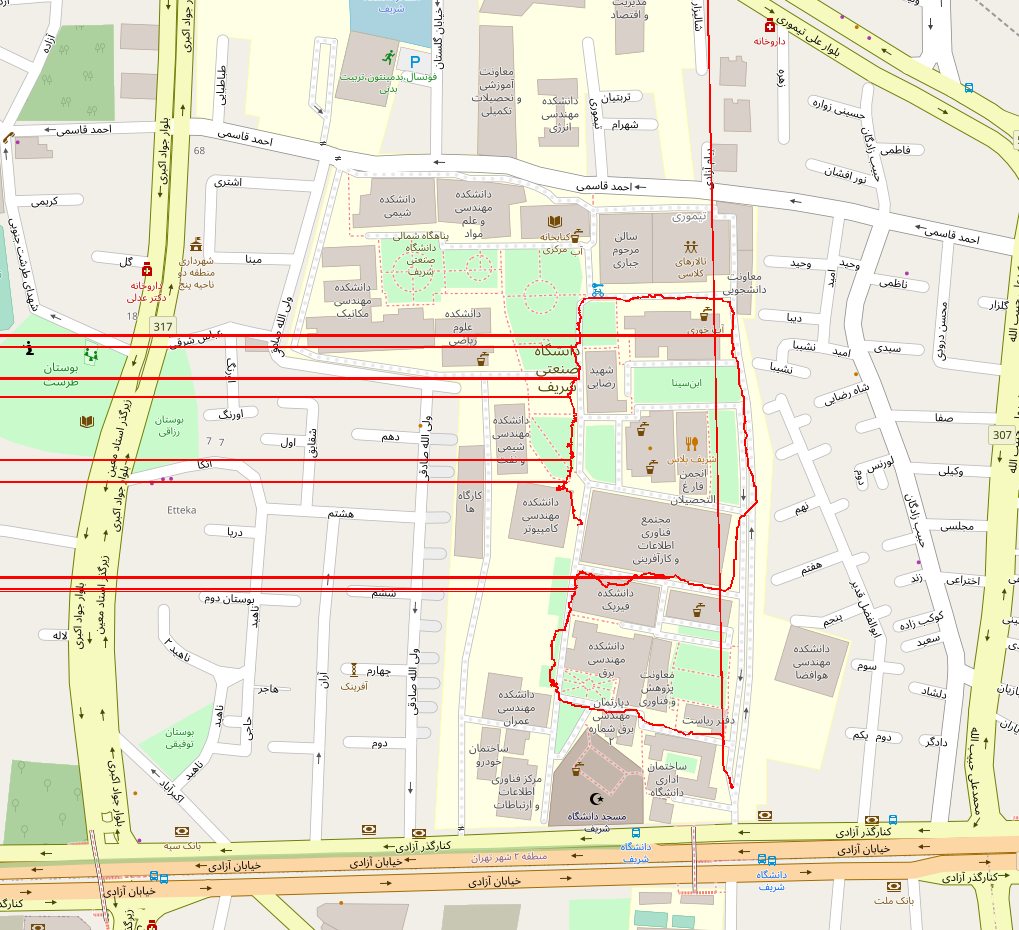

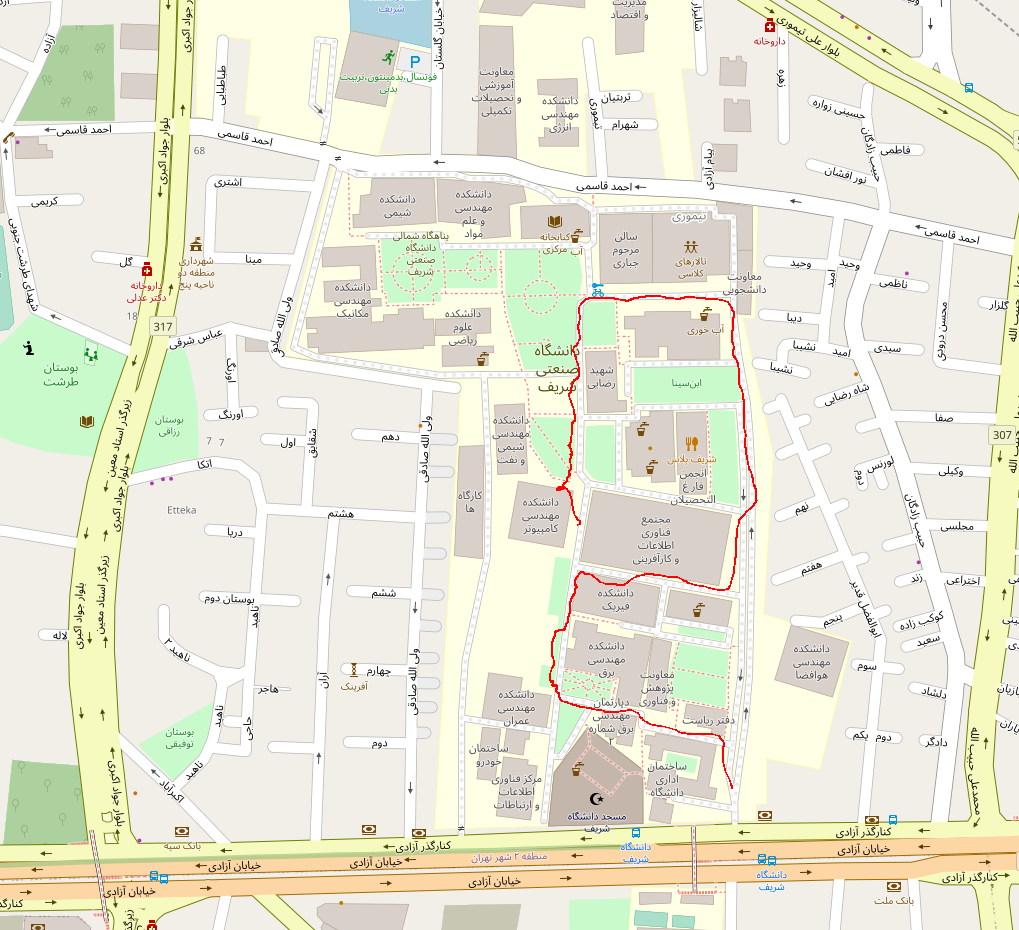

In [15]:
display(Image.open('resultMap.png'))
display(Image.open('resultMap2.png'))
display(Image.open('resultMap_uni.png'))
display(Image.open('resultMap_uni_norm.png'))

### kalman filter impalementation

implement kalman with zero order (without speed):

In [16]:
def ZeroOrderKF(R, Q, x0, P=20):
    """ Create zero order Kalman filter.
    Specify R and Q as floats."""
    
    kf = KalmanFilter(dim_x=2, dim_z=2)
    kf.x = np.array(x0)
    kf.R *= R
    kf.Q *= Q
    kf.P *= P
    kf.F = np.eye(2)
    kf.H = np.eye(2)
    return kf

km = ZeroOrderKF(np.eye(2), np.eye(2), data[0])
test_km = ZeroOrderKF(np.eye(2), np.eye(2), test_data[0])
uni_km = ZeroOrderKF(np.eye(2), np.eye(2), uni[0])
norm_uni_km = ZeroOrderKF(np.eye(2), np.eye(2), norm_uni[0])

train and predict data sets by kalman:

In [17]:
ps, cov, _, _ = km.batch_filter(data, update_first=True)

In [18]:
test_ps, cov, _, _ = test_km.batch_filter(test_data, update_first=True)

In [19]:
uni_ps, cov, _, _ = uni_km.batch_filter(uni, update_first=True)

In [20]:
norm_uni_ps, cov, _, _ = norm_uni_km.batch_filter(norm_uni, update_first=True)

In [21]:
data[:6]

[[35.71065, 51.34312],
 [35.71065, 51.34313],
 [35.71066, 51.34313],
 [35.71066, 51.34312],
 [35.71066, 51.34312],
 [35.71067, 51.34312]]

In [22]:
ps[:6]

array([[35.71065   , 51.34312   ],
       [35.71065   , 51.34312661],
       [35.71065624, 51.34312873],
       [35.71065857, 51.34312333],
       [35.71065945, 51.34312127],
       [35.71066597, 51.34312049]])

In [23]:
test_data[:6]

[[45.825866, 16.043631],
 [45.825998, 16.0437],
 [45.826003, 16.043703],
 [45.82601, 16.043708],
 [45.826071, 16.043746],
 [45.826079, 16.043751]]

In [24]:
def plot(data, predicted, legend):
    data = np.array(data)
    predicted = np.array(predicted)
    plt.figure(figsize=(19,15))
    plt.plot(data[:,0], data[:,1], 'r--', predicted[:,0], predicted[:, 1], 'b--')
    plt.legend(legend)

### plot of data sets

plot of real data and predicted:

sensor data:

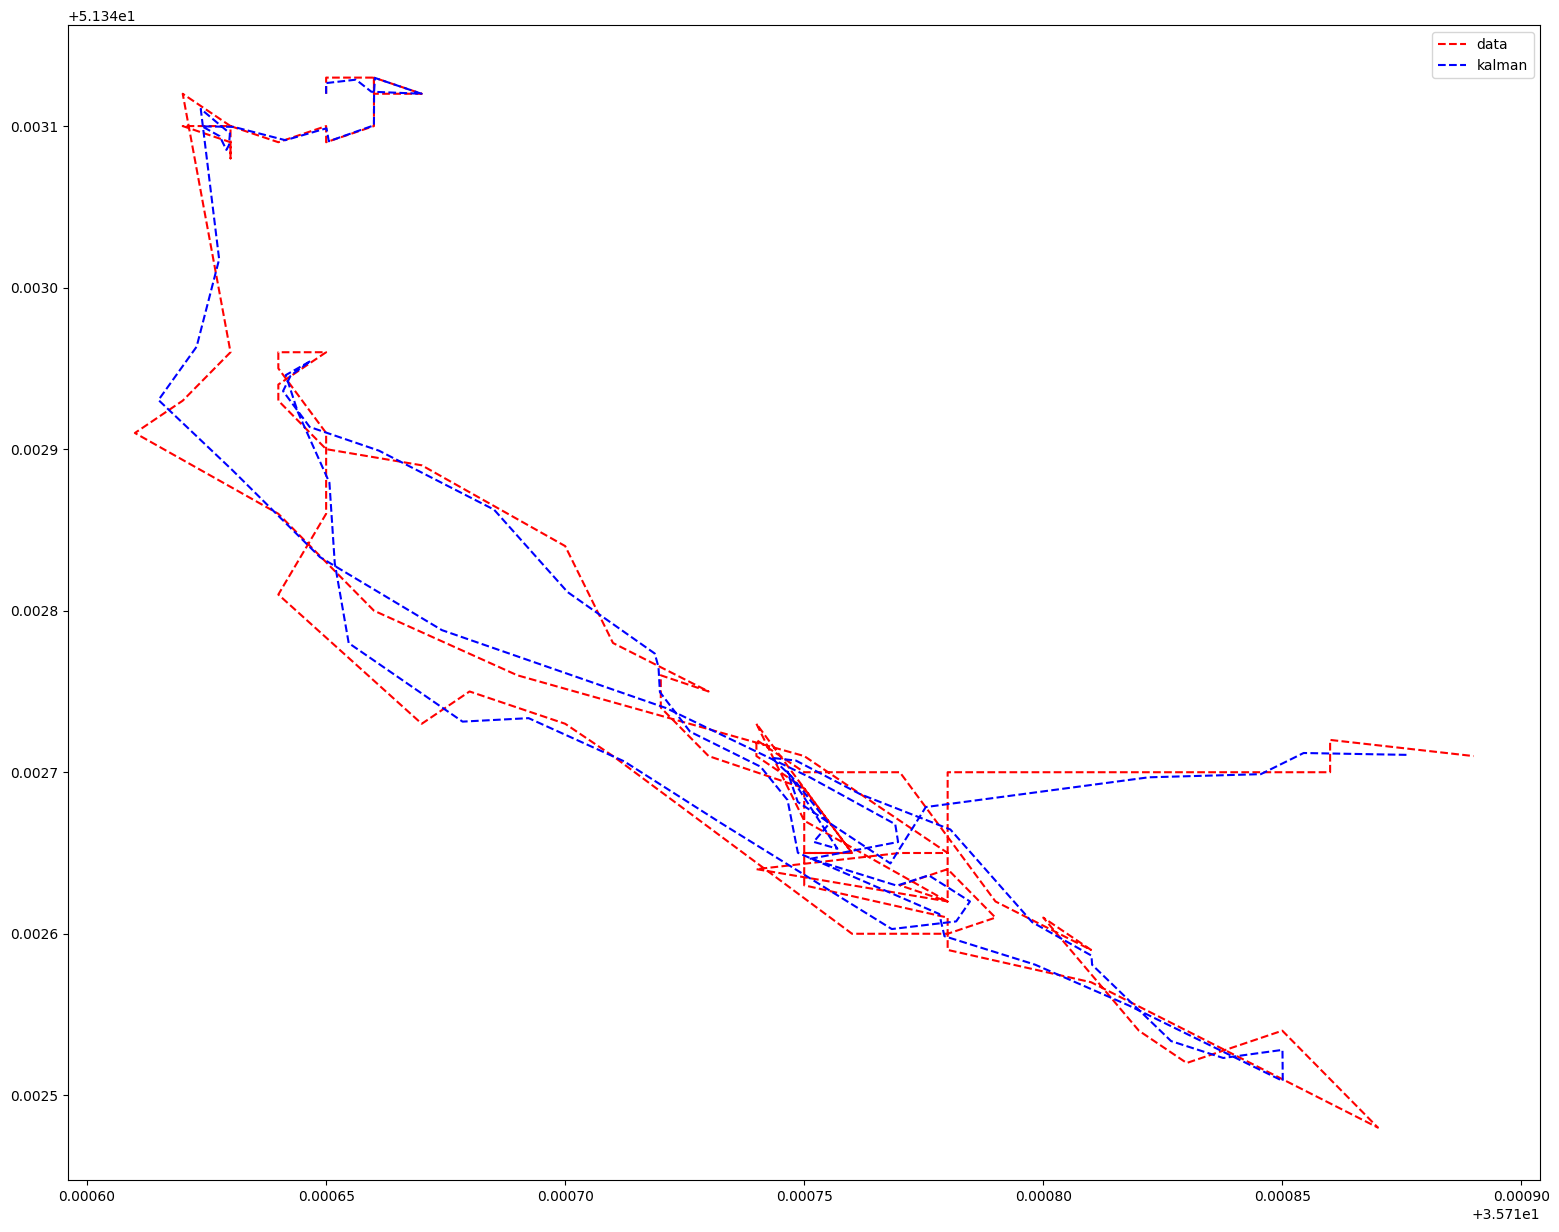

In [25]:
plot(data, ps, ["data", "kalman"])

test data:

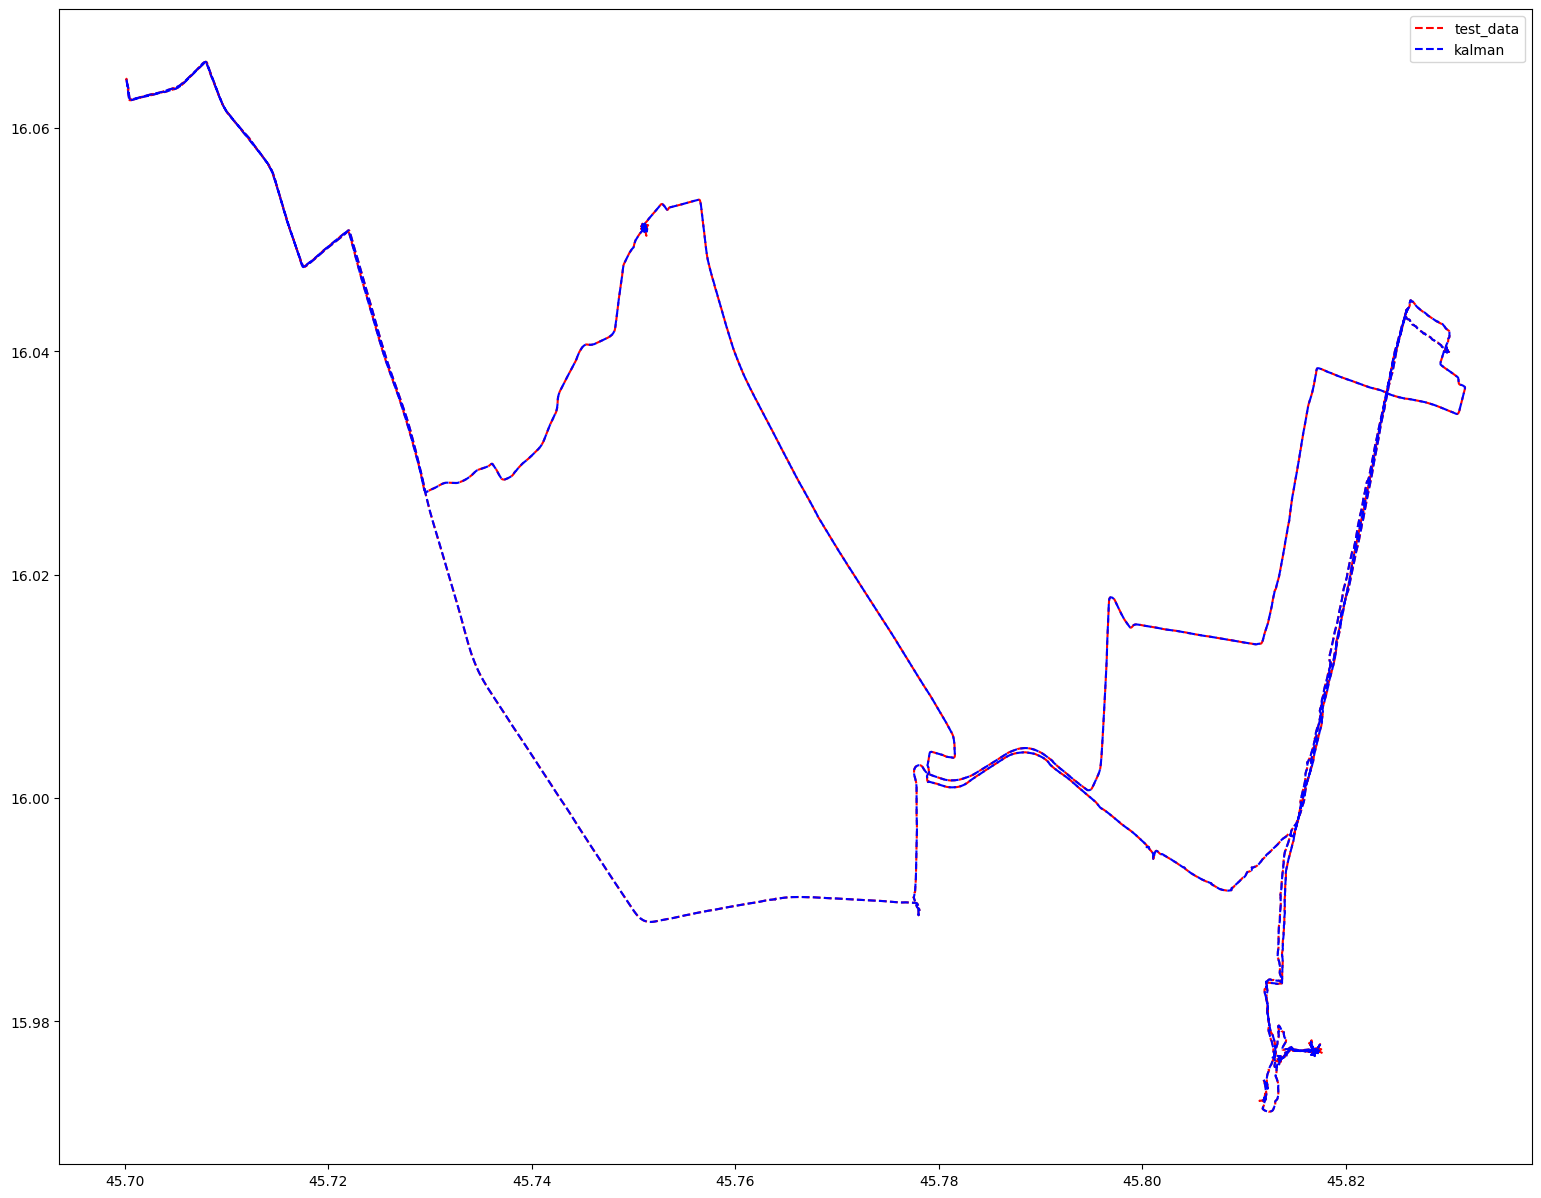

In [26]:
plot(test_data, test_ps, ["test_data", "kalman"])

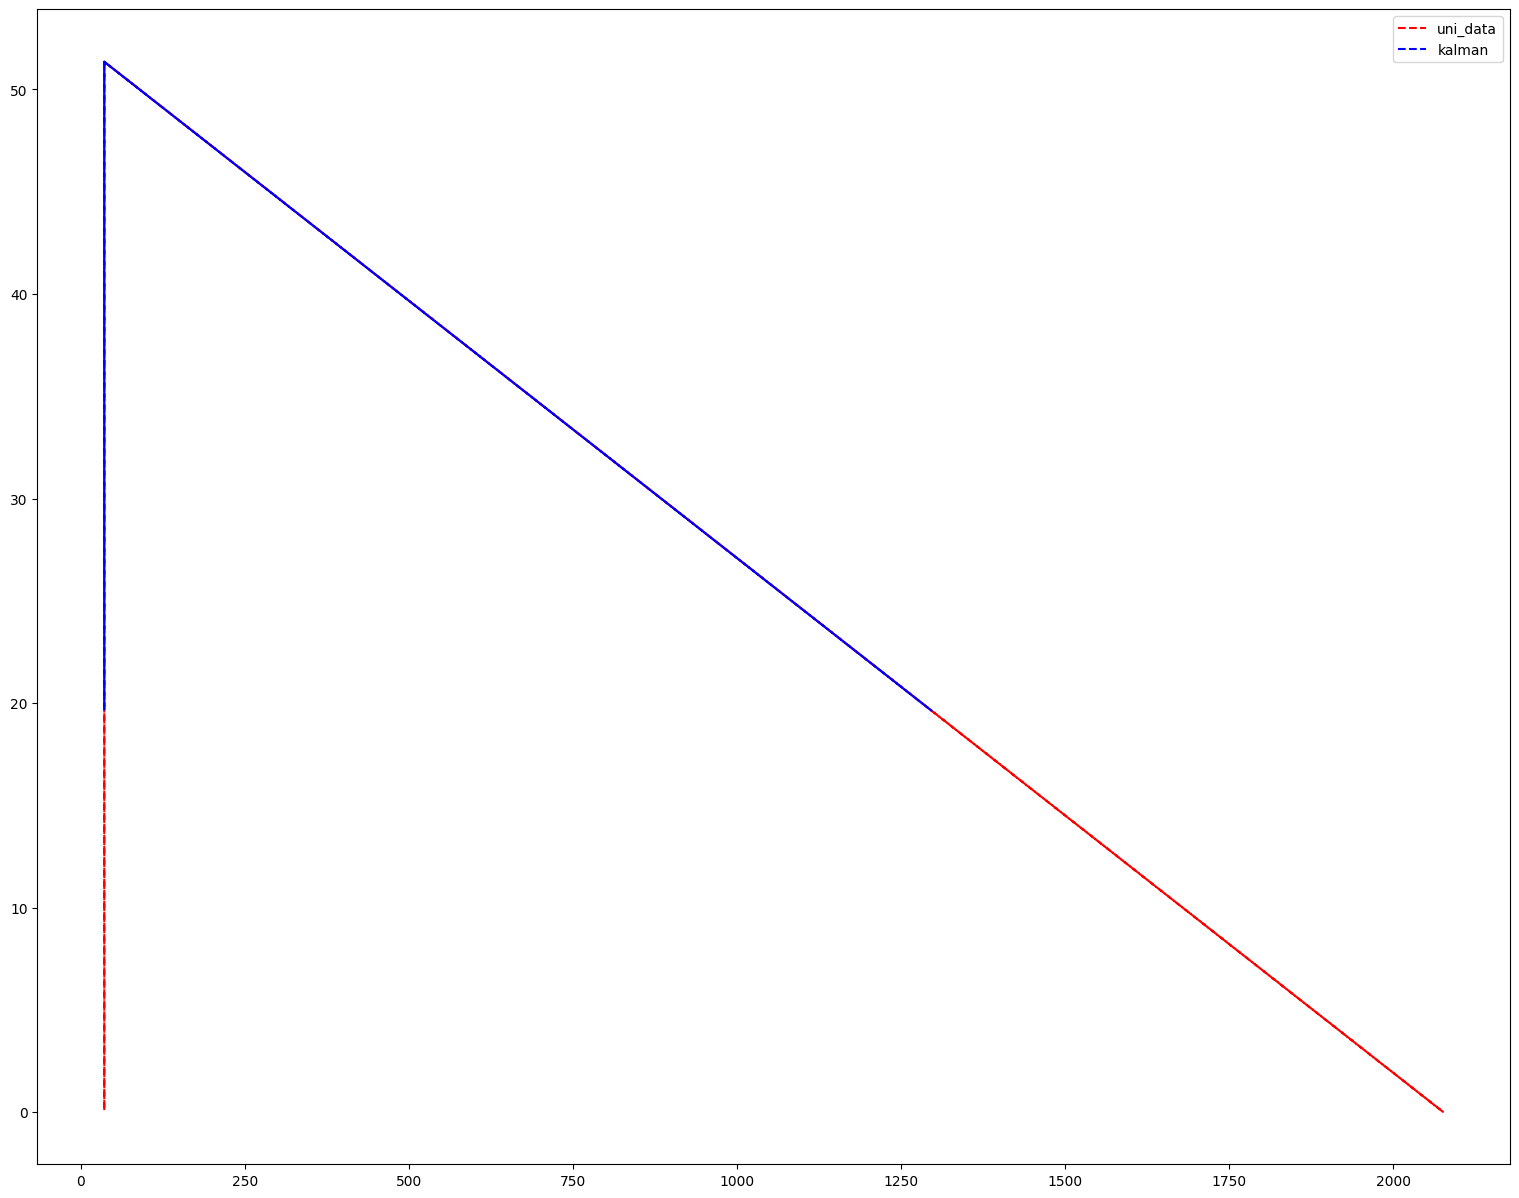

In [27]:
plot(uni, uni_ps, ["uni_data", "kalman"])

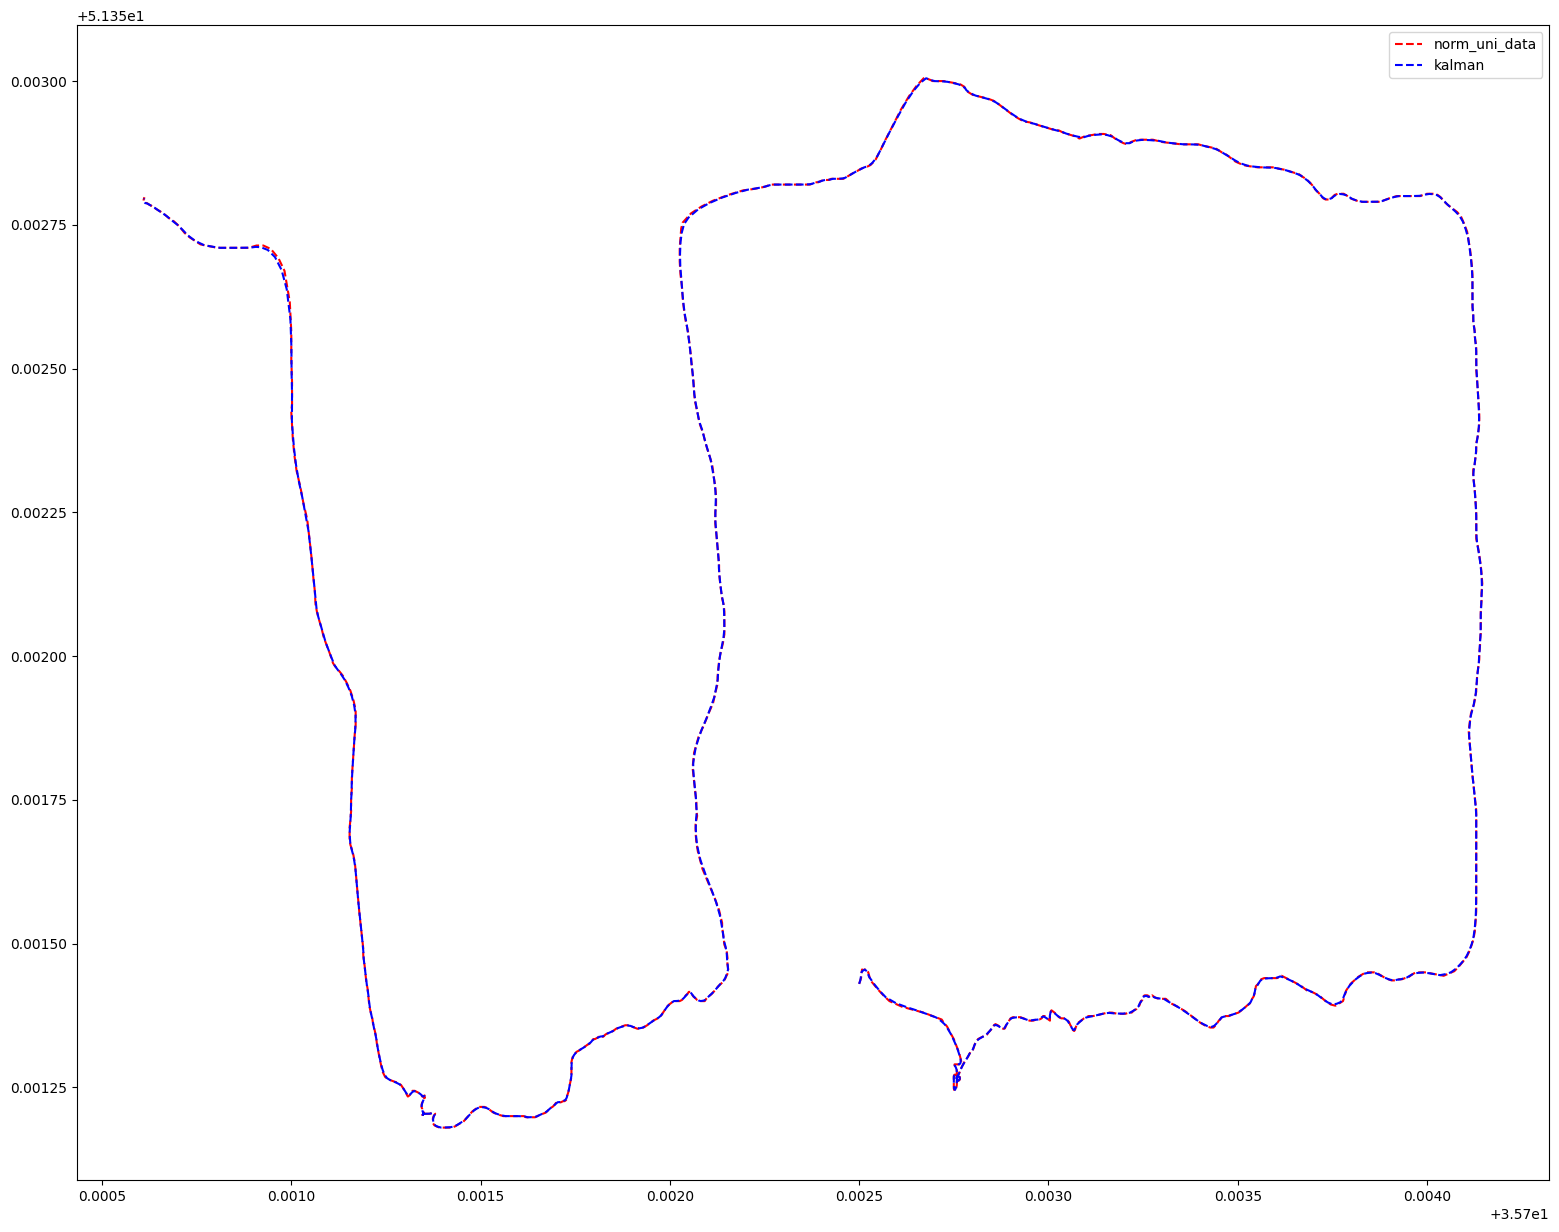

In [28]:
plot(norm_uni, norm_uni_ps, ["norm_uni_data", "kalman"])

### compute error of prediction


In [29]:
def compute_errs(data, predicted):
    errs = []
    for d, p in zip(data, predicted):
        errs.append(distance.distance(d, p).m)
    return errs

In [30]:
data_errs = compute_errs(data, ps)
test_data_errs = compute_errs(test_data, test_ps)
uni_errs = compute_errs(norm_uni, norm_uni_ps)

In [31]:
def plot_errs(errs, legend):
    plt.figure(figsize=(19,15))
    plt.plot(errs)
    plt.legend(legend)

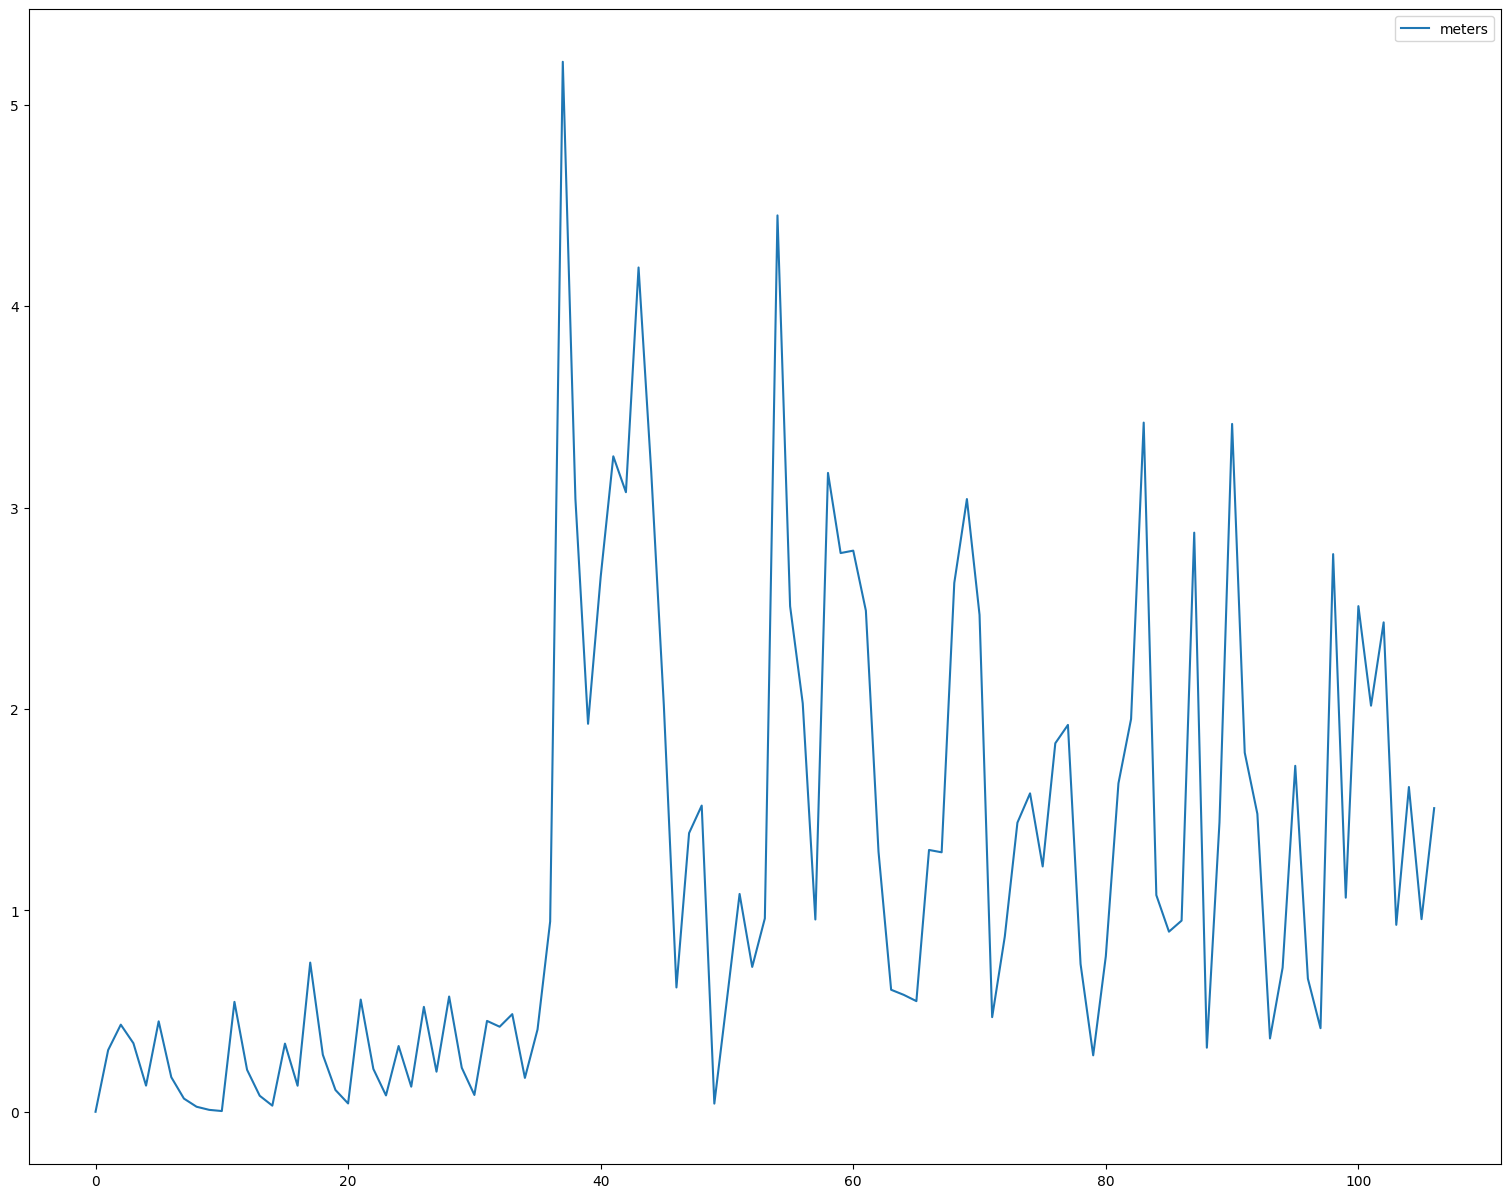

In [32]:
plot_errs(data_errs, ["meters"])

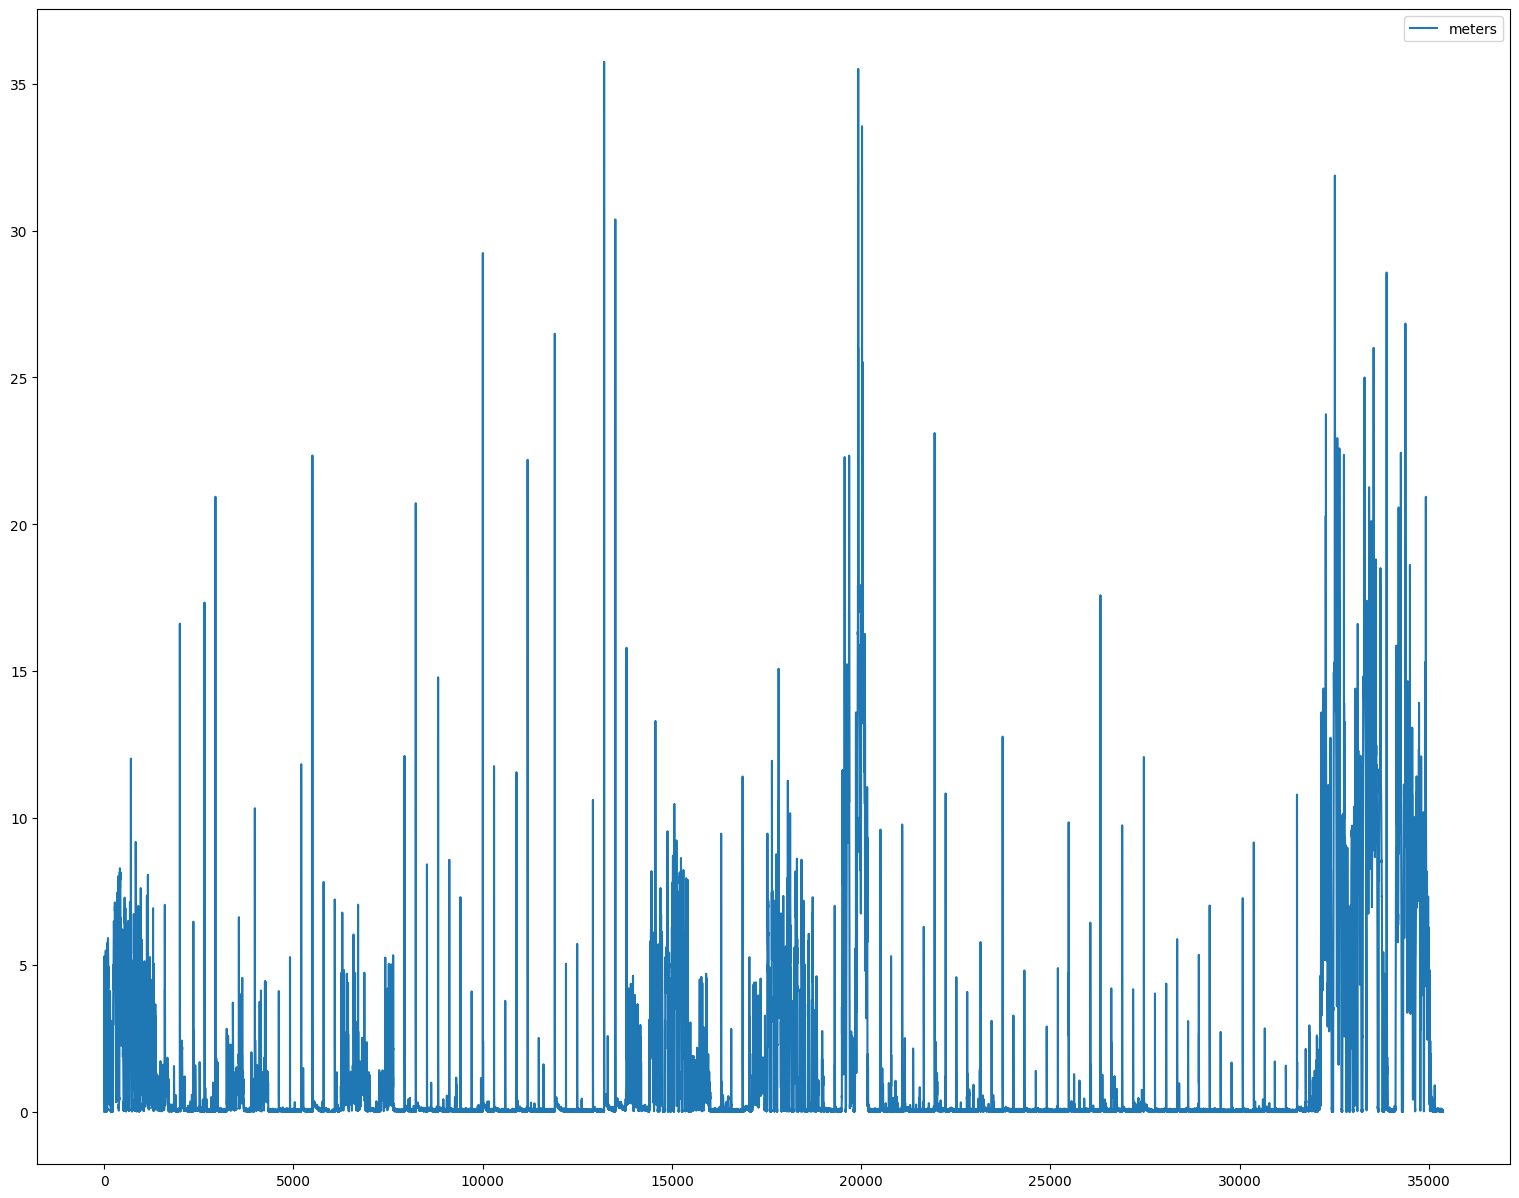

In [33]:
plot_errs(test_data_errs, ["meters"])

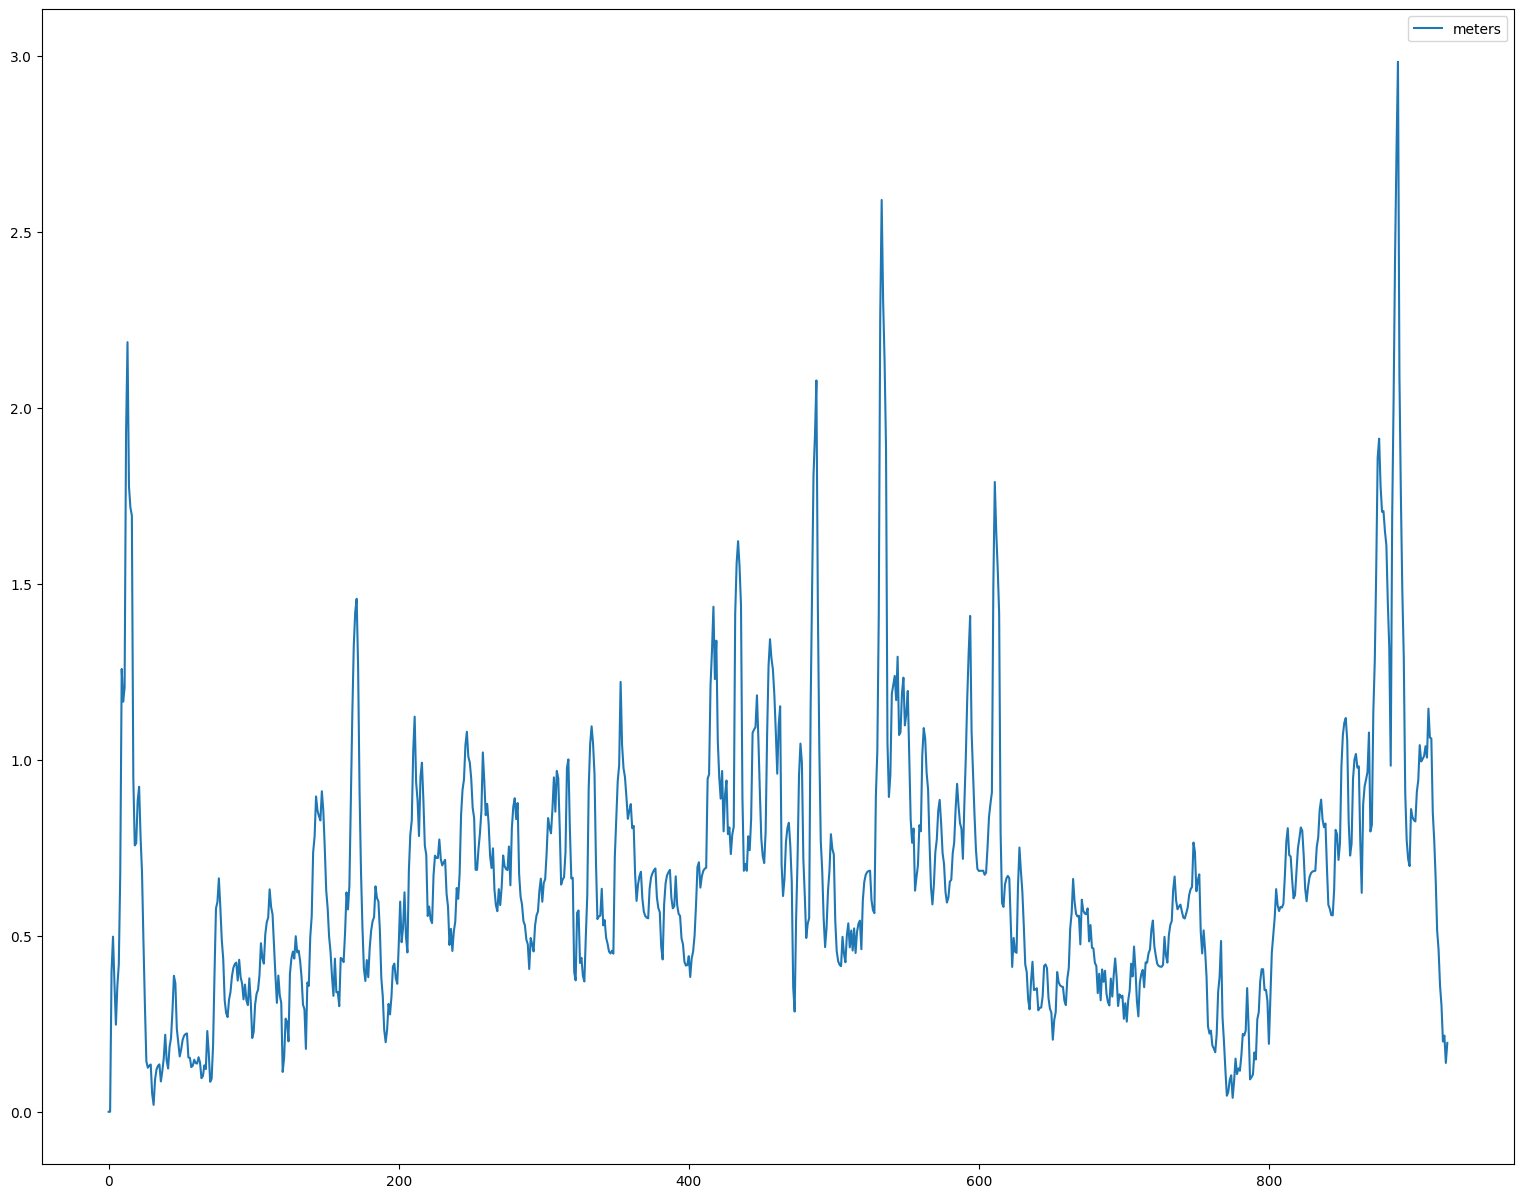

In [34]:
plot_errs(uni_errs, ["meters"])

In [35]:
np.mean(data_errs)

1.239083216181569

In [36]:
np.mean(uni_errs)

0.6620729688646962

### visualization



In [37]:
def plot_data_by_predicted_on_map(data, predicted, mapName, resultMapName, points):
    image = Image.open(mapName, 'r')  # Load map image.
    img_points = []
    for d in data:
        x1, y1 = scale_to_img(d, (image.size[0], image.size[1]), points)  # Convert GPS coordinates to image coordinates.
        img_points.append((x1, y1))
    draw = ImageDraw.Draw(image)
    draw.line(img_points, fill=(255, 0, 0), width=2)  # Draw converted records to the map image.

    for d in predicted:
        x1, y1 = scale_to_img(d, (image.size[0], image.size[1]), points)  # Convert GPS coordinates to image coordinates.
        img_points.append((x1, y1))
    draw.line(img_points, fill=(0, 0, 255), width=1)  # Draw converted records to the map image.

    image.save(resultMapName)

In [38]:
plot_data_by_predicted_on_map(test_data, test_ps, 'map2.png', 'resultMapKalman2.png', (45.8357, 15.9645, 45.6806, 16.1557))
plot_data_by_predicted_on_map(data, ps, 'map.png', 'resultMapKalman.png', (35.71138, 51.34097, 35.70805, 51.34548))
plot_data_by_predicted_on_map(uni, uni_ps, 'map_uni.png', 'resultMapKalmanUni.png', (35.70626, 51.34632, 35.69958, 51.35533))
plot_data_by_predicted_on_map(norm_uni, norm_uni_ps, 'map_uni.png', 'resultMapKalmanUniNorm.png', (35.70626, 51.34632, 35.69958, 51.35533))

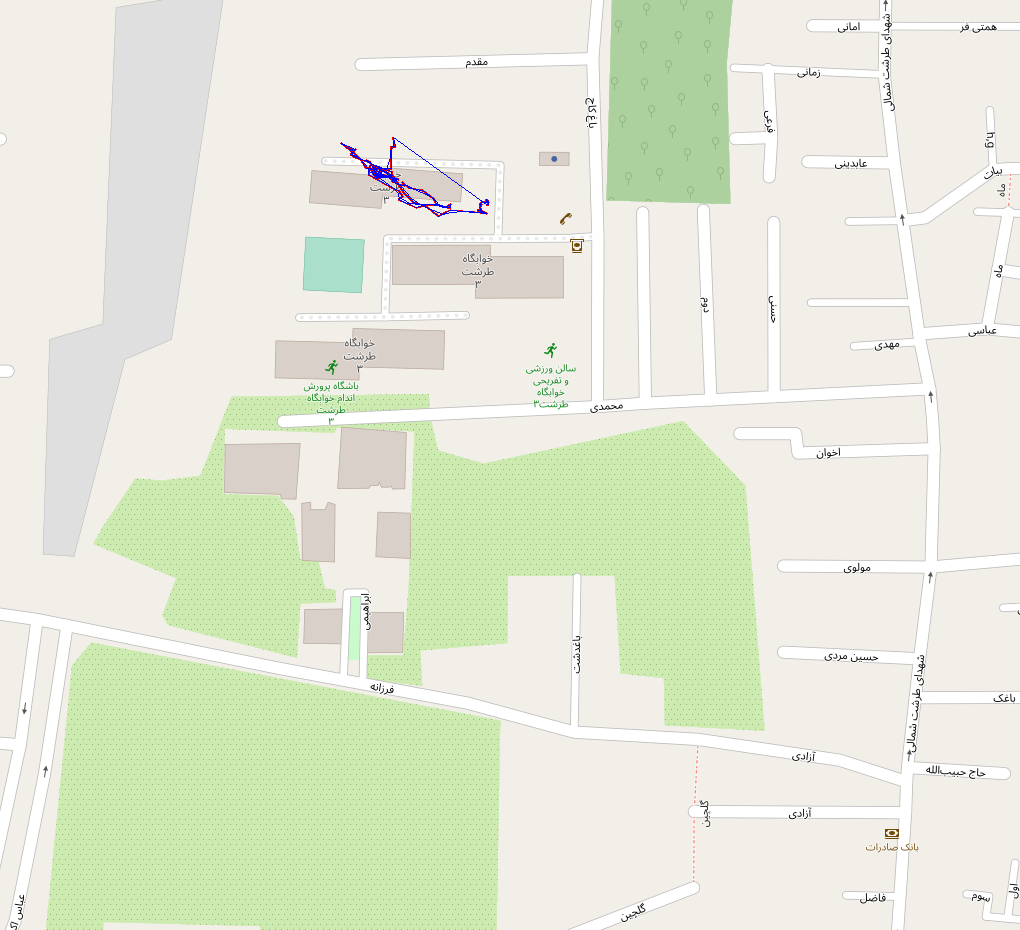

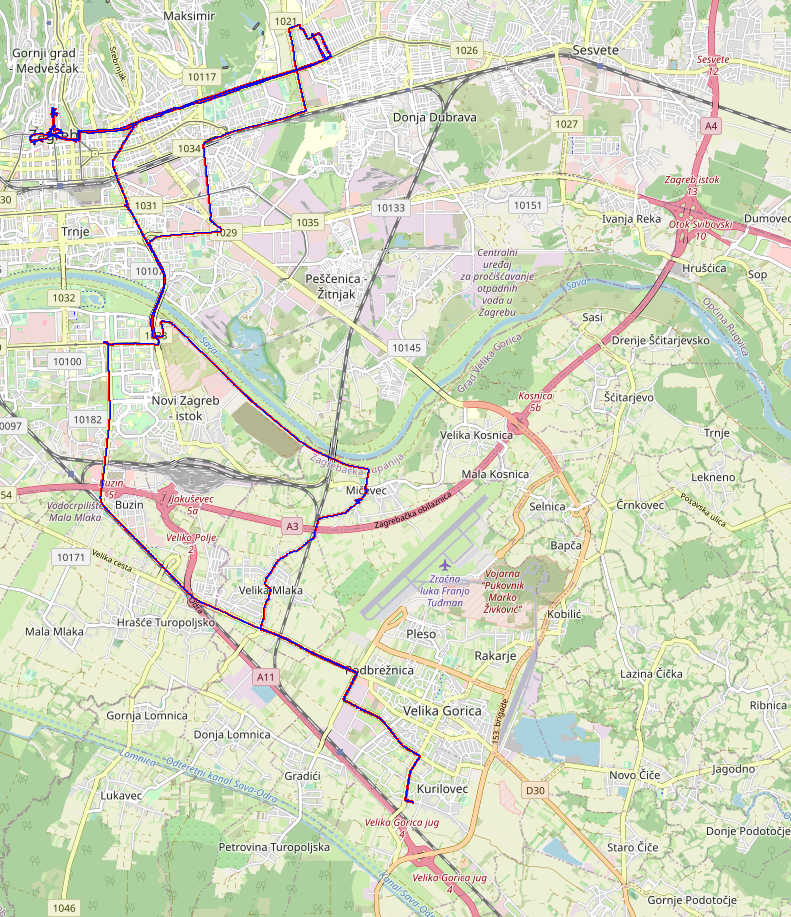

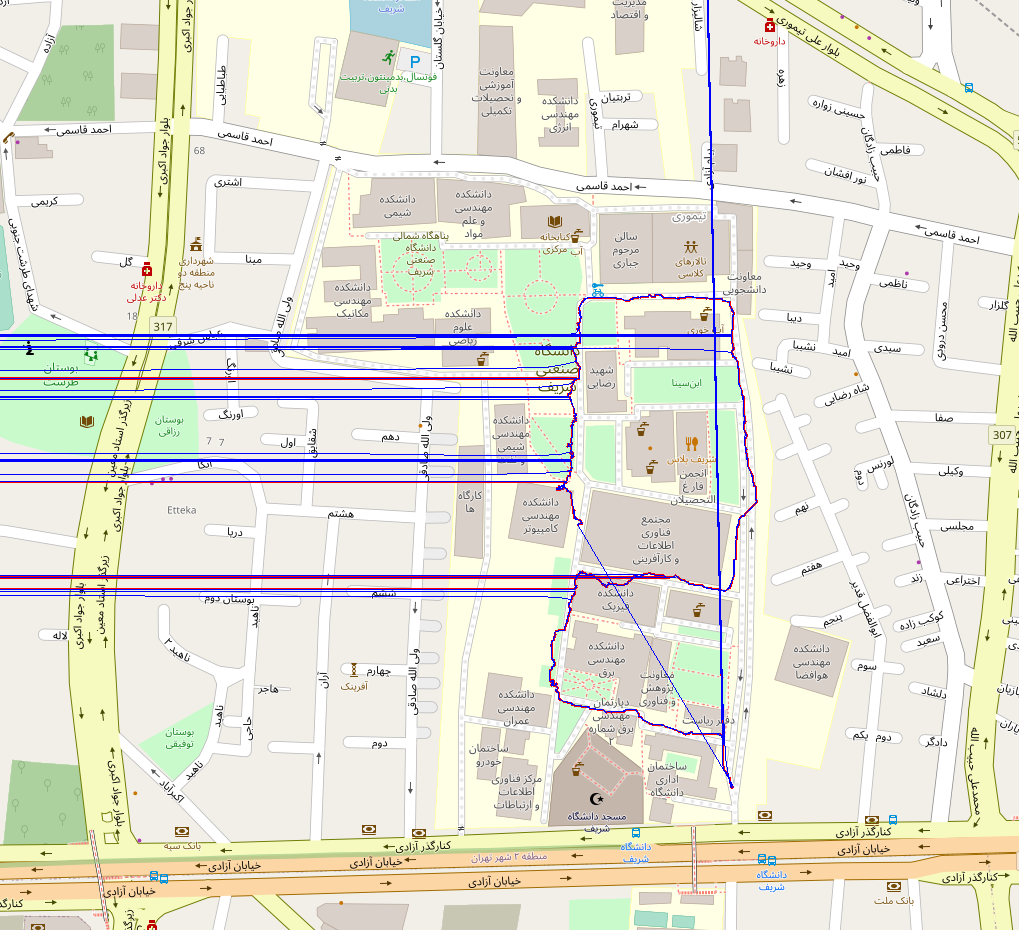

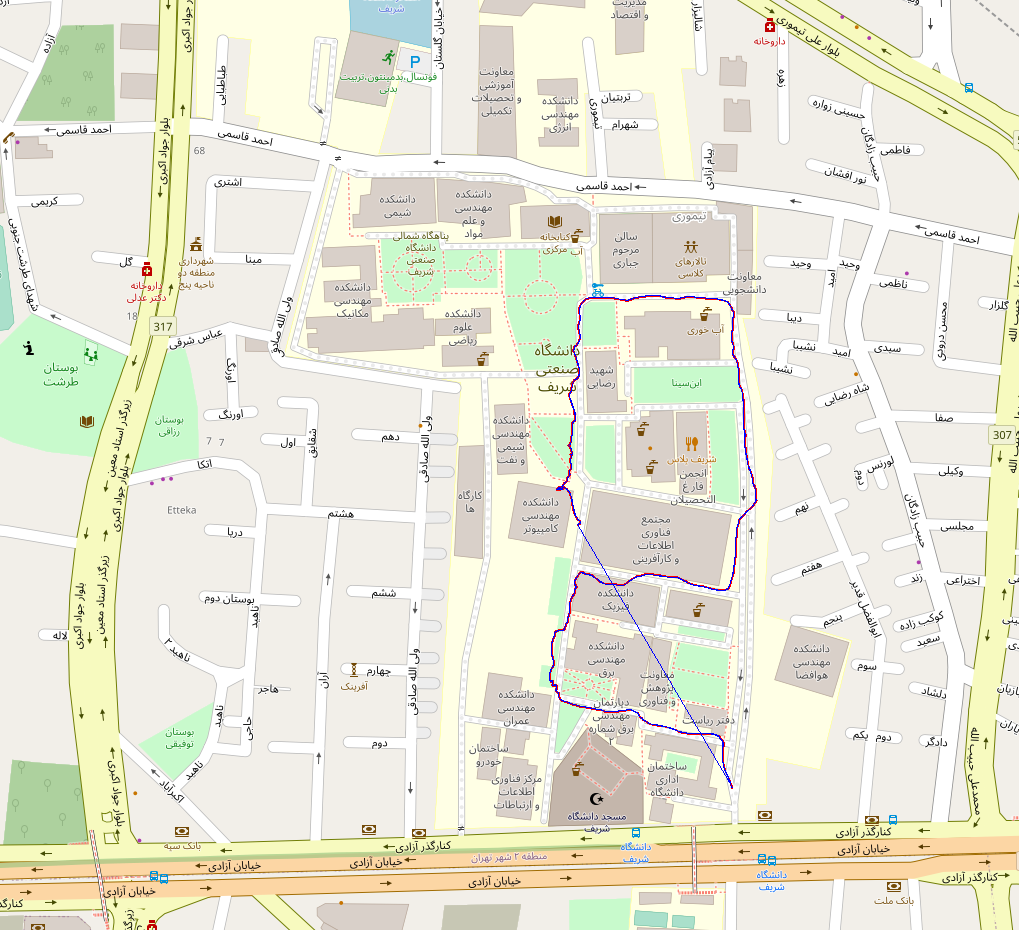

In [39]:
display(Image.open('resultMapKalman.png'))
display(Image.open('resultMapKalman2.png'))
display(Image.open('resultMapKalmanUni.png'))
display(Image.open('resultMapKalmanUniNorm.png'))